Letterboxd data loaded successfully.
Top Movies data loaded successfully.
Merging data...


/var/folders/74/yzd0624x7tz6twyhg_jbc6nr0000gn/T/ipykernel_46874/2928439587.py:22: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv("letterboxdata.csv", nrows=1000000)  # Assuming `merge_data` is a method from Letterboxd


Index(['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating',
       'top_actors_count', 'role', 'name_crew', 'type', 'language', 'studio',
       'country', 'genre'],
      dtype='object')
Merged data
Merged data saved to merged_data.csv
id                    int64
name                 object
date                float64
tagline              object
description          object
minute              float64
rating              float64
top_actors_count    float64
role                 object
name_crew            object
type                 object
language             object
studio               object
country              object
genre                object
revenue             float64
average_rating      float64
duration            float64
dtype: object
Categorical columns: ['description', 'role', 'type', 'language', 'country', 'genre']
<bound method NDFrame.head of              id    date                                        description  \
10030   1000005  2016.0  Mia, an aspi

/Users/addivuppala/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


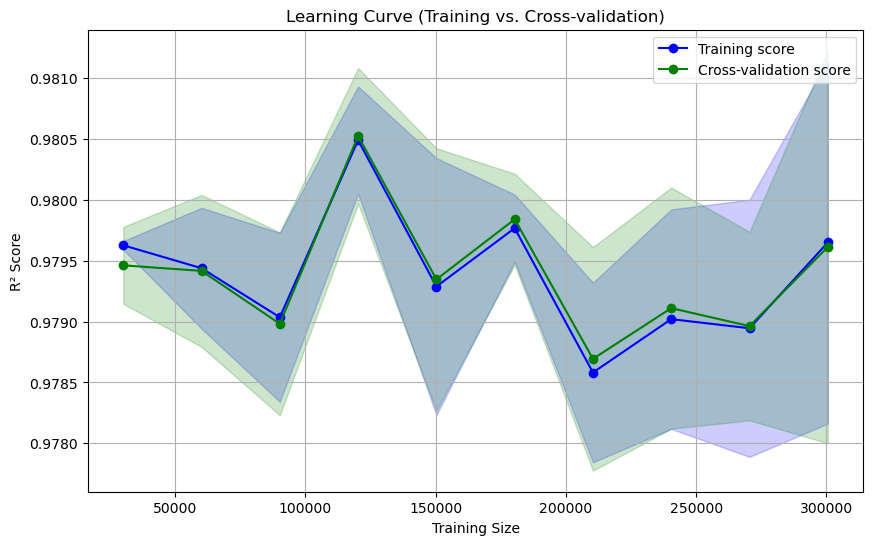

Training MAE: 16426153.827692145
Test MAE: 16506928.826625574
Training MSE: 828300767009085.5
Test MSE: 832020029058306.8
Best model saved to 'Random_Forest_Regressor_model_best.pkl'


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib  # To save the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import sys
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '../')))

from letterbox import Letterboxd
from revenue import RevenueData

def merge_data(letterboxd, revenue_data):
    """
    Merges the Letterboxd and revenue data based on movie names.
    Processes missing data, creates required features, and encodes non-integer variables.
    """
    print('Merging data...')
    merged_data = letterboxd.merge_data()
    merged_data = pd.read_csv("letterboxdata.csv", nrows=1000000)  # Assuming `merge_data` is a method from Letterboxd
    print(merged_data.columns)
    
    # Renaming revenue data for proper merging
    revenue_data_df = revenue_data.top_movies_data.rename(columns={'Movie': 'name', 'Lifetime Gross': 'revenue'})
    
    # Merge revenue data with the merged data on 'name'
    merged_data = merged_data.merge(revenue_data_df[['name', 'revenue']], on='name', how='left')
    print('Merged data')

    # Drop rows where revenue is missing
    merged_data = merged_data.dropna(subset=['revenue'])

    # Handling missing values in the 'rating' and 'minute' columns
    merged_data['average_rating'] = merged_data['rating'].fillna(0)
    merged_data['duration'] = merged_data['minute'].fillna(0)
    merged_data.to_csv('merged_data.csv', index=False)
    print('Merged data saved to merged_data.csv')
    print(merged_data.dtypes)

    merged_data = merged_data.drop(columns=['name', 'tagline', 'name_crew', 'studio'])

    # Automatically detect categorical columns based on their data type
    categorical_columns = merged_data.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"Categorical columns: {categorical_columns}")
    merged_data.to_csv('merged_data.csv', index=False)

    # One-Hot Encoding for categorical columns
    # merged_data['cleaned_description'] = merged_data['description'].apply(preprocess_text)
    merged_data = pd.get_dummies(merged_data, columns=['genre', 'language', 'country'], drop_first=True)
    print(merged_data.head)

    # Preprocess the 'description' column and add cleaned description as a new column

    return merged_data

from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import matplotlib.pyplot as plt
import joblib

def train_and_evaluate_model(merged_data):
    """
    Trains a RandomForestRegressor model on the merged data.
    Evaluates the model performance and displays the results.
    """
    X = merged_data.drop(columns=['revenue', 'description'])  # Drop unnecessary columns
    y = merged_data['revenue']

    print("Columns: ", X.columns)

    # Convert data to numeric and handle missing values
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Best hyperparameters found from previous RandomizedSearchCV
    best_params = {
        'n_estimators': 200,
        'max_depth': 10,
        'min_samples_split': 5,
        'min_samples_leaf': 3,
        'max_features': 'sqrt'
    }

    # Initialize the model with the best hyperparameters
    model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42
    )

    # Use learning_curve to get training and testing scores for different sizes of training data
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate mean and standard deviation of the training and testing scores
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plotting the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
    plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green', marker='o')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

    plt.title('Learning Curve (Training vs. Cross-validation)')
    plt.xlabel('Training Size')
    plt.ylabel('R² Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Train the model on the full training set
    model.fit(X_train, y_train)

    # Make predictions on the training and test sets
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)

    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)

    # Print MAE and MSE for both training and test sets
    print(f"Training MAE: {train_mae}")
    print(f"Test MAE: {test_mae}")
    print(f"Training MSE: {train_mse}")
    print(f"Test MSE: {test_mse}")

    # Save the best model
    joblib.dump(model, 'Random_Forest_Regressor_model_best.pkl')
    print("Best model saved to 'Random_Forest_Regressor_model_best.pkl'")


def main():
    """
    Main function to load data, merge it, and train the model.
    """
    base_path = "data"
    
    # Initialize data loaders
    letterboxd = Letterboxd(base_path)
    revenue_data = RevenueData(base_path)

    # Load data
    letterboxd.load_data()
    revenue_data.load_top_movies_data()

    # Merge the data
    merged_data = merge_data(letterboxd, revenue_data)


    # Train and evaluate the model
    train_and_evaluate_model(merged_data)

if __name__ == "__main__":
    main()
